In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random


Part I：LDPC Matrix Generation

In [18]:
def generate_regular_ldpc(n, dv, dc):
    """
    Generates a Regular LDPC Matrix using MacKay & Neal's construction (Algorithm 2).

    Parameters:
    n (int): Code length (number of columns / variable nodes).
    dv (int): Variable node degree (number of 1s per column).
    dc (int): Check node degree (number of 1s per row).

    Returns:
    tuple: (var_nodes, check_nodes) adjacency lists representing the Tanner Graph.
           Returns (None, None) if generation fails.
    """

    # --- Step 1: Calculate constraints ---
    # According to the conservation of edges: n * dv = m * dc
    # We must calculate the number of rows (m) derived from these parameters.
    if (n * dv) % dc != 0:
        print("Error: Invalid parameters. (n * dv) must be divisible by dc.")
        return None, None

    m = int((n * dv) / dc)

    print(f"Generating ({dv}, {dc})-Regular LDPC Code.")
    print(f"Structure: {n} Columns, {m} Rows.")

    # Safety mechanism: The algorithm is probabilistic and might hit a "dead end".
    # We allow a maximum number of retries before giving up.
    max_retries = 100
    attempt = 0

    # --- Step 2: The Construction Loop ---
    while attempt < max_retries:
        attempt += 1

        # Initialize the Adjacency Lists (The Tanner Graph Structure)
        # var_nodes[j] stores the list of row indices connected to column j.
        var_nodes = [[] for _ in range(n)]

        # check_nodes[i] stores the list of column indices connected to row i.
        check_nodes = [[] for _ in range(m)]

        # Keep track of how many connections each row currently has.
        # Initially, all rows have 0 connections.
        current_row_degrees = [0] * m

        success = True # Flag to verify if this attempt completes successfully

        # --- Step 3: Column-by-Column Filling ---
        for col_idx in range(n):

            # Find "Candidate Rows":
            # Identify all rows that have not yet reached the limit 'dc'.
            candidate_rows = []
            for row_idx in range(m):
                if current_row_degrees[row_idx] < dc:
                    candidate_rows.append(row_idx)

            # --- Deadlock Check ---
            # We must place 'dv' ones in the current column.
            # If valid candidate rows are fewer than 'dv', we cannot satisfy the constraint.
            if len(candidate_rows) < dv:
                success = False
                break # Break the inner loop to restart the process

            # --- Random Selection ---
            # Randomly select 'dv' distinct rows from the valid candidates.
            chosen_rows = random.sample(candidate_rows, dv)

            # --- Update Graph Connections ---
            for row_idx in chosen_rows:
                # 1. Update Variable Node (Column -> Rows)
                # This corresponds to "Bit-to-Check" connections.
                var_nodes[col_idx].append(row_idx)

                # 2. Update Check Node (Row -> Columns)
                # This corresponds to "Check-to-Bit" connections.
                check_nodes[row_idx].append(col_idx)

                # 3. Increment the weight counter for this row
                current_row_degrees[row_idx] += 1

        # --- Step 4: Final Validation ---
        if success:
            print(f"Success! Matrix generated on attempt {attempt}.")
            return var_nodes, check_nodes

    # If we exit the while loop, it means we failed after max_retries.
    print("Failed to generate matrix. Try increasing max_retries or checking parameters.")
    return None, None


In [19]:
# Test with the parameters from the slides or a small example
N = 12   # Number of columns
Dv = 3   # Ones per column
Dc = 4   # Ones per row

# Execute the function
v_nodes, c_nodes = generate_regular_ldpc(N, Dv, Dc)


Generating (3, 4)-Regular LDPC Code.
Structure: 12 Columns, 9 Rows.
Success! Matrix generated on attempt 3.


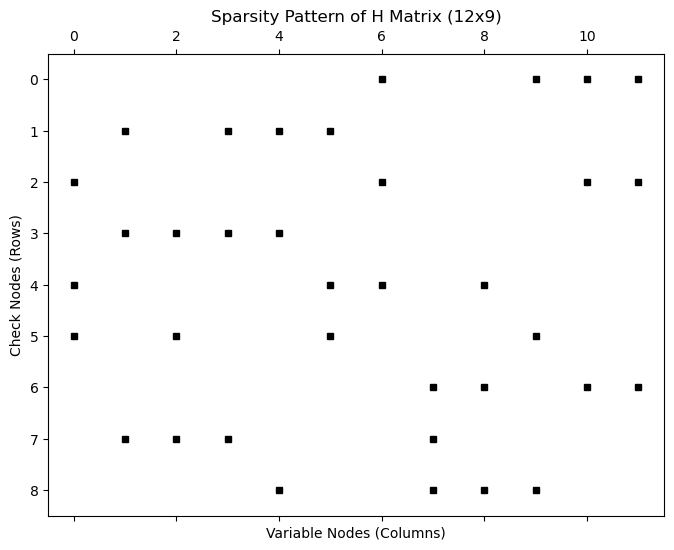

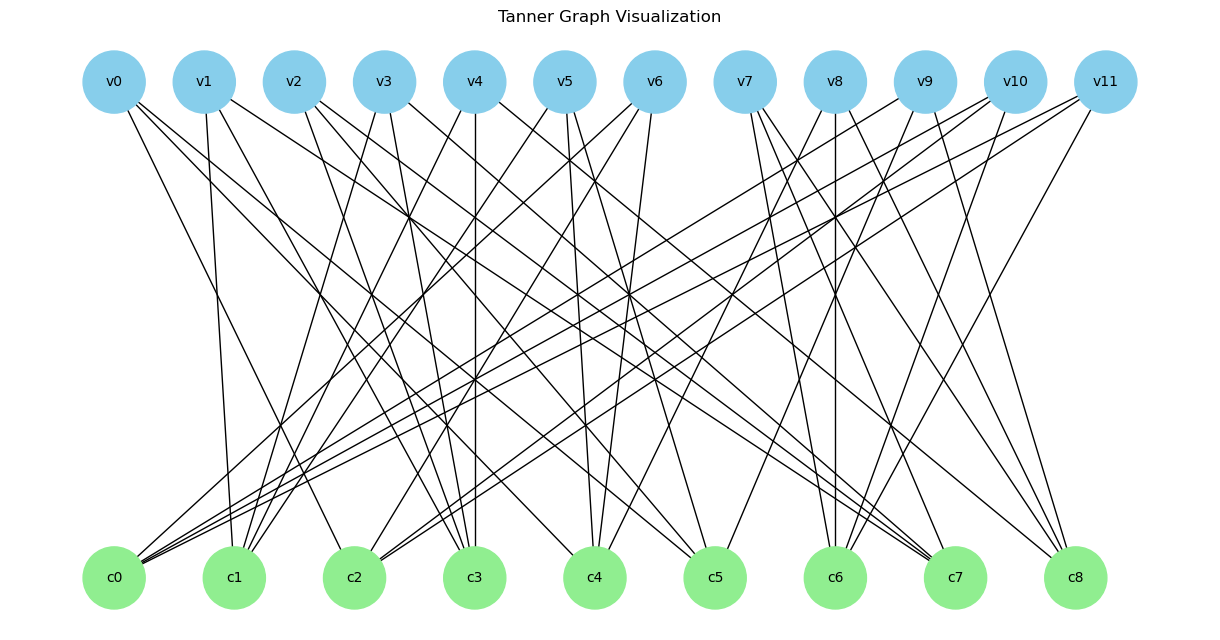

In [22]:
# Visualization

def visualize_matrix(n, m, var_nodes):
    """
    可视化 LDPC 矩阵 H 的稀疏结构
    """
    # 1. 先把邻接表转换回普通的 0/1 矩阵 (仅用于绘图)
    H = np.zeros((m, n))
    for col_idx, connected_rows in enumerate(var_nodes):
        for row_idx in connected_rows:
            H[row_idx, col_idx] = 1

    # 2. 使用 spy 函数绘制
    plt.figure(figsize=(10, 6))
    plt.spy(H, markersize=5, color='black') # markersize控制点的大小
    plt.title(f"Sparsity Pattern of H Matrix ({n}x{m})")
    plt.xlabel("Variable Nodes (Columns)")
    plt.ylabel("Check Nodes (Rows)")
    plt.grid(False)
    plt.show()

# --- 测试 ---
# 假设你已经有了 v_nodes 和 c_nodes
visualize_matrix(N, len(c_nodes), v_nodes)

import networkx as nx

def draw_tanner_graph(n, m, var_nodes):
    """
    画出漂亮的二部图 (仅限小规模 N < 20)
    """
    if n > 20:
        print("图太大了，画出来也看不清，跳过绘制。")
        return

    G = nx.Graph()

    # 1. 添加节点
    # 变量节点叫 v0, v1... 放在上方
    # 校验节点叫 c0, c1... 放在下方
    v_nodes_list = [f"v{j}" for j in range(n)]
    c_nodes_list = [f"c{i}" for i in range(m)]

    G.add_nodes_from(v_nodes_list, bipartite=0)
    G.add_nodes_from(c_nodes_list, bipartite=1)

    # 2. 添加边
    for col_idx, rows in enumerate(var_nodes):
        for row_idx in rows:
            G.add_edge(f"v{col_idx}", f"c{row_idx}")

    # 3. 设置布局 (二部图布局)
    pos = {}
    # 变量节点放上面 y=1
    for i, node in enumerate(v_nodes_list):
        pos[node] = (i, 1)
    # 校验节点放下面 y=0
    for i, node in enumerate(c_nodes_list):
        pos[node] = (i * (n/m), 0) # 稍微拉伸一下对齐

    # 4. 绘制
    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, with_labels=True,
            node_color=['skyblue']*n + ['lightgreen']*m,
            node_size=2000, font_size=10)
    plt.title("Tanner Graph Visualization")
    plt.show()

# --- 测试 ---
draw_tanner_graph(N, len(c_nodes), v_nodes)